In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [2]:
def gridSearch(X, Y, repeat, n_splits, scorer, mod, hyperparameters,  n_jobs=None, stratify=True):
    # GridSearch Wrapper Fucntion
    print("Number of repeats run is: " + str(repeat))
    dfL = []
    for i in range(0,repeat):
        if stratify==True:
            cv = StratifiedKFold(n_splits=n_splits, random_state=i, shuffle=True)
        else:
            cv = KFold(n_splits=n_splits, random_state=i, shuffle=True)
        boosted_grid = GridSearchCV(mod, hyperparameters, scoring=scorer, cv=cv, verbose=0, refit=True, error_score=np.nan, return_train_score=True, n_jobs=n_jobs) #n_jobs=n_jobs,
        grid_fit = boosted_grid.fit(X, Y)
        DF = pd.DataFrame(grid_fit.cv_results_)
        DF['Iteration'] = i
        dfL.append(DF)
    DFall = pd.concat(dfL)
    return DFall


def OverSampler(parentDIR,df, xfilename, yfilename):
    # Oversample small class to balanced data
    os.chdir(parentDIR)
    df = df.dropna()
    X = df.iloc[:,4:].copy()
    X = pd.get_dummies(X)
    Y = df.Status.copy()

    ros = RandomOverSampler(random_state=0)
    Xoversampled, Yoversampled = ros.fit_resample(X, Y)

    if not os.path.isdir('OverSampled'):
        os.makedirs('OverSampled')
    os.chdir('OverSampled')

    Xoversampled.to_csv(xfilename, sep='\t')
    Yoversampled.to_csv(yfilename, sep='\t')
    return Xoversampled, Yoversampled

In [3]:
parentdir = os.getcwd()
Clean = pd.read_csv('CleanedData.txt', sep='\t', index_col=0)
Clean.Status.replace('Melioid', 1, inplace=True)
Clean.Status.replace('Negative', 0, inplace=True)

Week4 = Clean.loc[(Clean['TimeGroup']=='Week4+')|(Clean['TimeGroup']=='Healthy')]
Week3 = Clean.loc[(Clean['TimeGroup']=='Week3')|(Clean['TimeGroup']=='Healthy')]
Week2 = Clean.loc[(Clean['TimeGroup']=='Week2')|(Clean['TimeGroup']=='Healthy')]
Week1 = Clean.loc[(Clean['TimeGroup']=='Week1')|(Clean['TimeGroup']=='Healthy')]
Prior = Clean.loc[(Clean['TimeGroup']=='Prior')|(Clean['TimeGroup']=='Healthy')]


In [4]:
X1, Y1 = OverSampler(parentdir, Week1, 'W1_predictor', 'W1_response')
X2, Y2 = OverSampler(parentdir, Week2, 'W2_predictor', 'W2_response')
X3, Y3 = OverSampler(parentdir, Week3, 'W3_predictor', 'W3_response')
X4, Y4 = OverSampler(parentdir, Week4, 'W4_predictor', 'W4_response')

In [5]:
os.chdir(parentdir)
os.chdir('OverSampled')
if not os.path.isdir('Results'):
    os.makedirs('Results')
os.chdir('Results')
RAND=np.random.RandomState(4)

param_space = {'C':np.logspace(-5,2,4),
                'l1_ratio':[float(x) for x in np.linspace(0.1,0.9,4)]}
enet = LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter=int(1e6))

Enet = gridSearch(X=X1, Y=Y1, repeat=50, n_splits=10, scorer='roc_auc', mod=enet, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
Enet.to_csv('W1_EnetBurkPx_GridSearch.txt', sep='\t')
Enet['params2'] = Enet['params'].astype(str)
print('Finished Enet')


param_space = {'C':np.logspace(-5,3,10),
                'penalty':['l1', 'l2']}
lr = LogisticRegression( solver = 'saga', max_iter=int(1e6))

LR = gridSearch(X=X1, Y=Y1, repeat=50, n_splits=10, scorer='roc_auc', mod=lr, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
LR.to_csv('W1_LRBurkPx_GridSearch.txt', sep='\t')
LR['params2'] = LR['params'].astype(str)
print('Finished LR')


param_space = {'learning_rate': np.logspace(-5, -3,4),
                'n_estimators': [25, 50],
                'subsample': np.linspace(0.6,0.9,2),
                'max_depth':[int(x) for x in np.linspace(5,25,3)]}

xgb =  XGBClassifier(objective='binary:logistic', colsample_bytree=0.25, eval_metric='logloss', random_state=RAND) #, scale_pos_weight=len(Y1==0)/len(Y1==1) BinaryFocalLoss

LR = gridSearch(X=X1, Y=Y1, repeat=50, n_splits=10, scorer='roc_auc', mod=xgb, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
LR.to_csv('W1_XGBBurkPx_GridSearch.txt', sep='\t')
LR['params2'] = LR['params'].astype(str)

Number of repeats run is: 50
Finished Enet
Number of repeats run is: 50
Finished LR
Number of repeats run is: 50


## Figures showing AUC of Tuned Models
### Elastic Net

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, "{'C': 1e-05, 'l1_ratio': 0.1}"),
  Text(1, 0, "{'C': 1e-05, 'l1_ratio': 0.3666666666666667}"),
  Text(2, 0, "{'C': 1e-05, 'l1_ratio': 0.6333333333333333}"),
  Text(3, 0, "{'C': 1e-05, 'l1_ratio': 0.9}"),
  Text(4, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.1}"),
  Text(5, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.3666666666666667}"),
  Text(6, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.6333333333333333}"),
  Text(7, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.9}"),
  Text(8, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.1}"),
  Text(9, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.3666666666666667}"),
  Text(10, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.6333333333333333}"),
  Text(11, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.9}"),
  Text(12, 0, "{'C': 100.0, 'l1_ratio': 0.1}"),
  Text(13, 0, "{'C': 100.0, 'l1_ratio': 0.3666666666666667}"),
  Text(14, 0, "{'C': 100.0, 'l1_ratio': 0.6

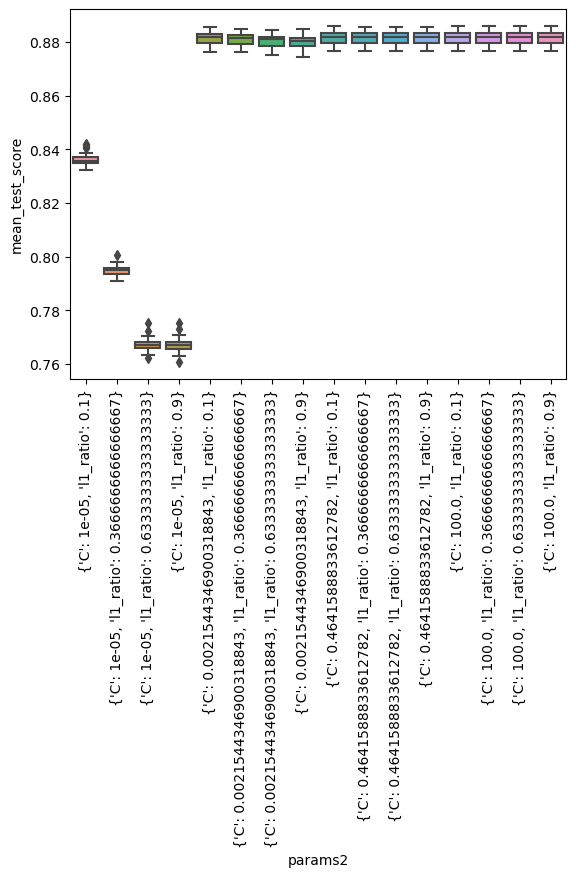

In [6]:
LR = pd.read_csv('W1_EnetBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

### Penalized Logit

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, "{'C': 1e-05, 'penalty': 'l1'}"),
  Text(1, 0, "{'C': 1e-05, 'penalty': 'l2'}"),
  Text(2, 0, "{'C': 7.742636826811278e-05, 'penalty': 'l1'}"),
  Text(3, 0, "{'C': 7.742636826811278e-05, 'penalty': 'l2'}"),
  Text(4, 0, "{'C': 0.0005994842503189409, 'penalty': 'l1'}"),
  Text(5, 0, "{'C': 0.0005994842503189409, 'penalty': 'l2'}"),
  Text(6, 0, "{'C': 0.004641588833612777, 'penalty': 'l1'}"),
  Text(7, 0, "{'C': 0.004641588833612777, 'penalty': 'l2'}"),
  Text(8, 0, "{'C': 0.03593813663804626, 'penalty': 'l1'}"),
  Text(9, 0, "{'C': 0.03593813663804626, 'penalty': 'l2'}"),
  Text(10, 0, "{'C': 0.2782559402207126, 'penalty': 'l1'}"),
  Text(11, 0, "{'C': 0.2782559402207126, 'penalty': 'l2'}"),
  Text(12, 0, "{'C': 2.154434690031882, 'penalty': 'l1'}"),
  Text(13, 0, "{'C': 2.154434690031882, 'penalty': 'l2'}"),
  Text(14, 0, "{'C': 16.681005372000556, 'penalty': 'l1'}"),
  Text(

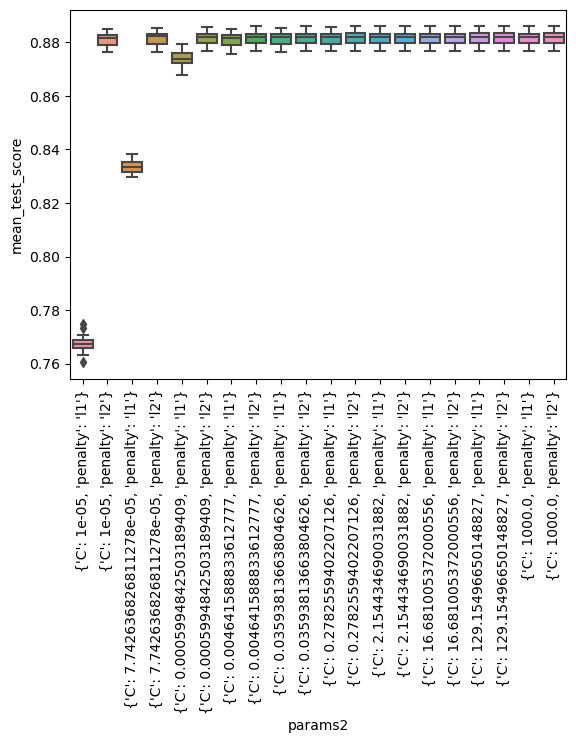

In [7]:
LR = pd.read_csv('W1_LRBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

### XGB

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 [Text(0, 0, "{'learning_rate': 1e-05, 'max_depth': 5, 'n_estimators': 25, 'subsample': 0.6}"),
  Text(1, 0, "{'learning_rate': 1e-05, 'max_depth': 5, 'n_estimators': 25, 'subsample': 0.9}"),
  Text(2, 0, "{'learning_rate': 1e-05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}"),
  Text(3, 0, "{'learning_rate': 1e-05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9}"),
  Text(4, 0, "{'learning_rate': 1e-05, 'max_depth': 15, 'n_estimators': 25, 'subsample': 0.6}"),
  Text(5, 0, "{'learning_rate': 1e-05, 'max_depth': 15, 'n_estimators': 25, 'subsample': 0.9}"),
  Text(6, 0, "{'learning_rate': 1e-05, 'max_depth': 15, 'n_estimators': 50, 'subsample': 0.6}"),
  Text(7, 0, "{'learning_rate': 1e-05, 'max_depth': 15, 'n_estimators': 50, 'subsample': 0.9}"),
  Text(8, 

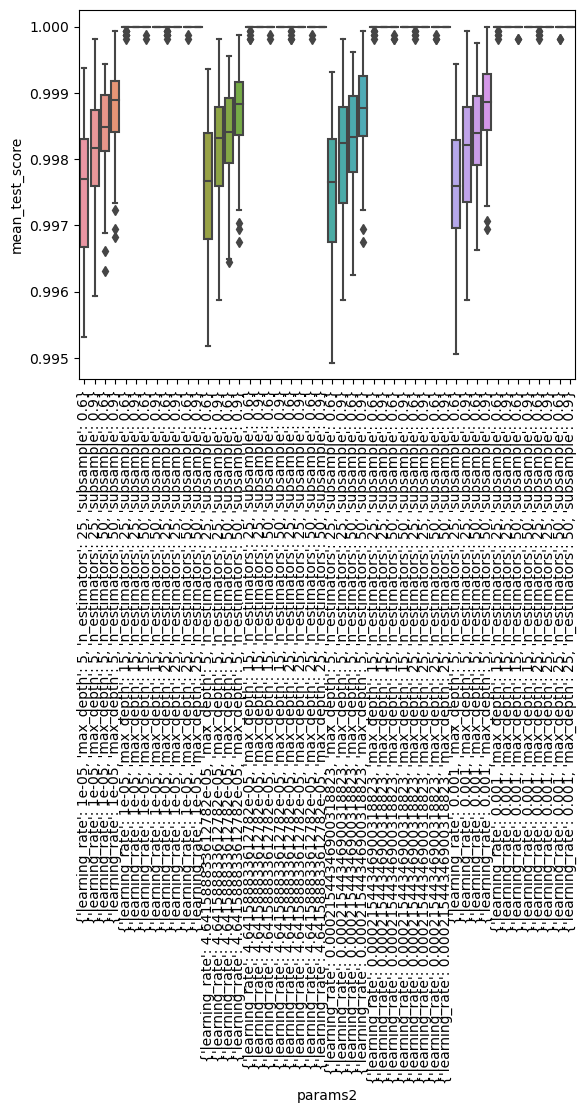

In [8]:
LR = pd.read_csv('W1_XGBBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

### Combined Best Tuned Models

/var/folders/20/192vzyys2_b6v3q3tlh1tmd40000gn/T/ipykernel_8996/203571552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W1Enet['Model']  = 'ElasticNet'
/var/folders/20/192vzyys2_b6v3q3tlh1tmd40000gn/T/ipykernel_8996/203571552.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W1XGB['Model'] = 'XGB'


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'LASSO_Weak'),
  Text(1, 0, 'LASSO_Strong'),
  Text(2, 0, 'Ridge_Weak'),
  Text(3, 0, 'Ridge_Strong'),
  Text(4, 0, 'ElasticNet'),
  Text(5, 0, 'XGB')])

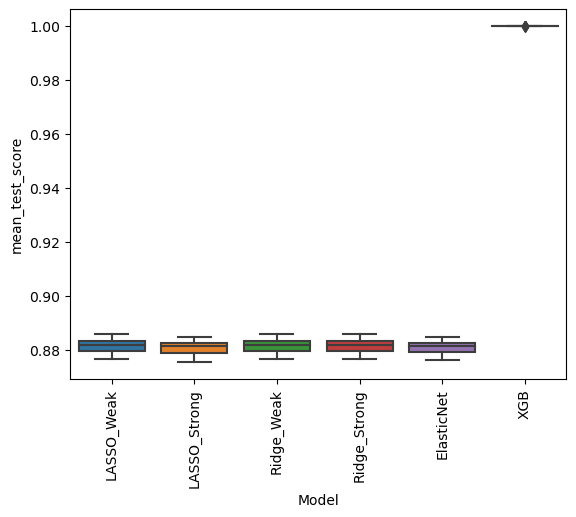

In [11]:
LR = pd.read_csv('W1_EnetBurkPx_GridSearch.txt', sep='\t', index_col=0)
W1Enet = LR.loc[LR['params'] =="{'C': 0.0021544346900318843, 'l1_ratio': 0.3666666666666667}"]
W1Enet['Model']  = 'ElasticNet'

LR = pd.read_csv('W1_LRBurkPx_GridSearch.txt', sep='\t', index_col=0)
W1LASSOWeak=LR.loc[LR['params']== "{'C': 1000.0, 'penalty': 'l1'}"].copy()
W1LASSOWeak['Model'] = 'LASSO_Weak'

W1LASSOstrong=LR.loc[LR['params']== "{'C': 0.004641588833612777, 'penalty': 'l1'}"].copy()
W1LASSOstrong['Model'] = 'LASSO_Strong'

W1RIDGEWeak=LR.loc[LR['params']== "{'C': 1000.0, 'penalty': 'l2'}"].copy()
W1RIDGEWeak['Model'] = 'Ridge_Weak'

W1RIDGEstrong=LR.loc[LR['params']== "{'C': 0.004641588833612777, 'penalty': 'l2'}"].copy()
W1RIDGEstrong['Model'] = 'Ridge_Strong'


LR = pd.read_csv('W1_XGBBurkPx_GridSearch.txt', sep='\t', index_col=0)
W1XGB = LR.loc[LR['params']=="{'learning_rate': 1e-05, 'max_depth': 25, 'n_estimators': 25, 'subsample': 0.6}"]
W1XGB['Model'] = 'XGB'
BEST = pd.concat([W1LASSOWeak, W1LASSOstrong, W1RIDGEWeak, W1RIDGEstrong, W1Enet, W1XGB])

BEST['params2'] = BEST['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=BEST, y= 'mean_test_score', x='Model', ax=ax)

plt.xticks(rotation=90)

## Analyzing Validation Set
### Enet

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
os.chdir('/Users/paulmacos/githubrepos/public/BurkPx_BuscagliaPhillips/data/RAW/ValidationSet')

df = pd.read_csv('ValidationSet.txt', sep='\t', index_col=0)
Week1 = df.loc[(df['TimeGroup']=='Week1')|(df['TimeGroup']=='Healthy')]

yVAL = Week1.Status.copy()
yVAL.replace('Melioid', 1, inplace=True)
yVAL.replace('Negative', 0, inplace=True)

XVAL = Week1.iloc[:,4:].copy()
XVAL = pd.get_dummies(XVAL)
enet = LogisticRegression(penalty = 'elasticnet', C=0.0021544346900318843, l1_ratio=0.3666666666666667, solver = 'saga', max_iter=int(1e6)).fit(XVAL, yVAL)
# roc_auc_score(y, clf.predict_proba(X)[:, 1])
roc_auc_score(yVAL, enet.predict_proba(XVAL)[:, 1])
# roc_auc_score(yVAL, enet.decision_function(XVAL))

0.95

### Logit

In [28]:
os.chdir('/Users/paulmacos/githubrepos/public/BurkPx_BuscagliaPhillips/data/RAW/ValidationSet')

df = pd.read_csv('ValidationSet.txt', sep='\t', index_col=0)
Week1 = df.loc[(df['TimeGroup']=='Week1')|(df['TimeGroup']=='Healthy')]

yVAL = Week1.Status.copy()
yVAL.replace('Melioid', 1, inplace=True)
yVAL.replace('Negative', 0, inplace=True)

XVAL = Week1.iloc[:,4:].copy()
XVAL = pd.get_dummies(XVAL)
LR = LogisticRegression(penalty = 'l1', C=0.004641588833612777, solver = 'saga', max_iter=int(1e6)).fit(XVAL,yVAL)
roc_auc_score(yVAL, LR.predict_proba(XVAL)[:, 1])

0.95

## XGB

In [32]:
os.chdir('/Users/paulmacos/githubrepos/public/BurkPx_BuscagliaPhillips/data/RAW/ValidationSet')

df = pd.read_csv('ValidationSet.txt', sep='\t', index_col=0)
Week1 = df.loc[(df['TimeGroup']=='Week1')|(df['TimeGroup']=='Healthy')]

yVAL = Week1.Status.copy()
yVAL.replace('Melioid', 1, inplace=True)
yVAL.replace('Negative', 0, inplace=True)

XVAL = Week1.iloc[:,4:].copy()
XVAL = pd.get_dummies(XVAL)
xgb =  XGBClassifier(objective='binary:logistic', colsample_bytree=0.25, eval_metric='logloss', random_state=RAND, learning_rate=0.001, max_depth=15, n_estimators=25, subsample=0.6).fit(XVAL,yVAL)
roc_auc_score(yVAL, xgb.predict_proba(XVAL)[:, 1])

0.9333333333333333